<a href="https://colab.research.google.com/github/rabadgp/uimp-DL/blob/master/Entrega_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final - Fase II: Implementación de la solución propuesta

## 1. Introducción

El problema planteado trata sobre una tarea de regresión utilizando técnicas de deep learning basadas den CNNs a partir de un dataset de imágenes proporcionado, del que desea estimar el porcentaje de pixels correspondientes a comida que exiten en una imagen dada.

Para la resolución del problema se ha optado por la utilización y adaptación de modelos pre-entrenados a partir de imágenes de ImageNet sobre los que incluirán un módulo de capas completamente conectadas. 

Los modelos considerados han sido los siguientes:

*   Xception: Presenta los mejores resultados en términos de precisión con un  tamaño y número de parámetros moderado/alto. 
*   VGG16: Arquitectura simple y homogénea basado en capas convolucionales completamente conectadas. Presenta un gran número de parámetros y tamaño por lo que la memoria necesaria para el entrenamiento en crítica. 
*   DenseNet121: Se trata de la evolución del modelo ResNet, ampliamente utilizado en aplicaciones prácticas. Se ha elegido por sus buenos resultados a pesar del reducido número de parámetros de entrenamiento.

## 2. Importar librerías

En este punto se procede a la importación de todas aquellas librerías necesarias para la implementación de la solución

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from google.colab import drive

from keras import applications
from keras import metrics
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.models import Model

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## 3. Preparación de datos

### 3.1 Carga de datos

El conjuto de datos de partida cuenta con un total de 1027 imágenes con una resolución de 640x480 píxeles y una separación de 3 canales según RGB con una profundidad de color de 8 bits.

Estas imágenes se encuentran disponibles en la siguiente ruta relativa al fichero: .*/UNIMIB2016/images/[nombre_fichero].jpg*.

Se cuenta además con el porcentaje de pixels correspondientes a comida en cada una de las imágenes. Esta información se encuentra disponible en el fichero *./UNIMIB2016/percentage.csv* con el siguiente esquema:

* *image_name*: nombre de la imagen en ./UNIMIB2016/images/ en formato *.jpg en formato str
* *food_pixels*: porcentaje de píxeles de comida expresado en tanto por cien y formato Float64

In [2]:

# Montamos el Google Drive en el directorio del proyecto el fichero DL_UNIMIB2016.zip y descomprimimos los ficheros:
#   /UNIMIB2016/images/*.jpg
#   /UNIMIB2016/percentages.csv
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/DL_master/DL_UNIMIB2016.zip' >> /dev/null

# Especificamos las rutas a los directorios que contienen las imágenes y el fichero de porcentajes
base_path = 'UNIMIB2016/'
img_path = base_path + 'images/'
pct_path = base_path + 'percentage.csv'

# Especificamos la estructura del fichero percentages.csv y el tamaño de la imagen
x_col = 'image_name'
y_col = 'food_pixels'
resize_factor=2
img_channels=3
img_size = [640,480]
img_shape = [dim//resize_factor for dim in img_size] + [img_channels]

# Lectura del fichero de CSV con los porcentajes
df = pd.read_csv(pct_path, dtype={y_col:'Float64'})

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 3.2 Obtención de los subconjuntos de entrenamiento, validación y prueba
Los subcojuntos de entrenamiento pruebas cuentan con un tamaño del 70% y 30% del dataset original, respectivamente, lo que supone un total de 718 y 309 instancias. El subconjuto de validación, con un total de resultando con un total de 154 instancias, ha sido obtenido a partir del subconjuto de test (50%) para evitar un posible sobreajuste del modelo durante la fase de entrenamiento.

Por último, el tamaño del batch considerado en el entrenamiento ha sido de 32 instancias debido a limitaciones de recursos en el entorno de ejecución y a la resolución de las imágenes, las cuales se han reducido a un tamañao de 320x240.

Ademas, con el objetivo de mejorar la robusted del modelo y evitar el sobreajuste, se han utilizado las siguientes técnicas de data augmentation para la generación de los diferentes subconjuntos, teniendo en cuenta que quedan descartadas todas aquellas transformaciones sobre las imágenes que puedan modificar el porcentaje de píxeles de comida del fichero percentage.csv:

• Reescale: normalización de los valores de las imágenes a un rango [0,1] aplicando un factor 1.0/255

• Color shifting: alteración de los canales RGB por un factor comprendido en el rango [1,0.8]

• Mirroring: generación de imágenes simétricas respecto al eje vertical y horizontal

• Brightness: variabilidad aleatoria del brillo de la imagen con un factor en el rango [0.5,1.0]


In [3]:
# Creamos las particiones de entrenamiento y test y se actualizan los índice de cada partición
# train_data = 70%
# validation_data = 50% test_data
# test_data = 30%
seed = 986
train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Peparamos el conjunto de datos de entrenamiento y validación utilizando técnicas de data augmentation
# Las técnicas utilizadas no deberán modificar el porcentaje de pixels de la imágen original por lo que transformaciones de giro, desplazamiento y zoom están descartadas
# Se han considerando el volteo horizontal y vertical de imágenes, el cambio del rango del canal según un valor factor aleatorio en el rango [1,0.2] y la normalización de características

img_generator = ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=0.8,
    brightness_range=[0.5,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.5) # Se define un subconjunto de validación de 1/2 sobre el subconjuto de test, para evitar overffiting durante el entrenamiento

# Generamos los batches para las particiones de train, validation y test
batch_size = 32
train_data_gen = img_generator.flow_from_dataframe(dataframe=train_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size)
val_data_gen = img_generator.flow_from_dataframe(dataframe=test_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size, subset='validation')
test_data_gen = img_generator.flow_from_dataframe(dataframe=test_data, directory=img_path, x_col=x_col, y_col=y_col, class_mode='raw',
                                               target_size=img_shape[:-1], batch_size=batch_size)


Found 718 validated image filenames.
Found 154 validated image filenames.
Found 309 validated image filenames.


## 4 Construcción de los modelos

### 4.1. Obtención de los modelos pre-entrenados
Con el objetivo de adaptar las arquitecturas de CNNs consideradas a la tarea de regresión objeto del trabajo se ha descartado el módulo de capas complemtamente conectada para incluir un nuevo módulo basado en una capa oculta con 1024 neuronas y una capa de salida con 1 neurona, ambas capas completamenta conectadas y con función de activación ReLU. 

Además de las técnicas de data augmentation, se ha optado por la combinación de transfer learning junto con fine-tuning con el objetivo de recalcular los parámetros del modelo durante el proceso de entrenamiento y mejorando su ajuste para la tarea de regresión a partir de las imágenes del dataset original.

Como algoritmo de optimización se ha utilizado Adam, con un learning rate inicial de 10^-5 y un decay de 10^-2 en cada iteración


In [0]:
def retrive_model(model_name, weights='imagenet', trainable=True, include_top=False, dropout=True, input_shape=img_shape, pooling='avg'):
  if model_name is 'DenseNet121':
    model = applications.DenseNet121(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  elif model_name is 'VGG16':
    model = applications.VGG16(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  elif model_name is 'Xception':
    model = applications.Xception(weights=weights, include_top=include_top, input_shape=input_shape, pooling=pooling)
  else: 
    raise ValueError('Model name not found')

  if not trainable:
    for layer in model.layers:
      model.trainable = trainable

  model = create_top_layer(model, dropout)
  model.summary()
  model.compile(loss='mean_squared_error',     # función de pérdida para problemas de regresión
                optimizer=optimizers.adam(lr=1e-5, decay=1e-2))  # optimizador Adam, learning rate (lr)
  return model
  
def create_top_layer(model, dropout, n_cells=[1024,1], activations=['relu','relu']):
  x = model.output
  for idx_layer in range(len(n_cells)-1):
    x = Dense(n_cells[idx_layer], activation=activations[idx_layer])(x)
    if dropout:
      x = Dropout(rate=0.2)(x)
  predictions = Dense(n_cells[-1], activation=activations[-1])(x)
  return Model(inputs=[model.input], outputs=[predictions], name=model.name)


### 4.2 Entrenamiento y evaluación de los modelos

El procedimiento en este punto es el de obtener os modelos, entrenarlos y validarlos con los subconjutos de datos correspondientes y representar gráficamente los resultados de la función de perdida (SME) por cada iteración.

Por último, se evaluarán los modelos entrenados frente al subconjuto de test.


Máximo error: 120.95343466889406
Mínimo error: 3.3815712692438686
Model: VGG16	SME: 3.755938240625326
Máximo error: 197.72814109108666
Mínimo error: 2.7355624232278273
Model: DenseNet121	SME: 4.95970701013954
Máximo error: 205.22668501517515
Mínimo error: 2.9009237942820736
Model: Xception	SME: 7.482032004297744


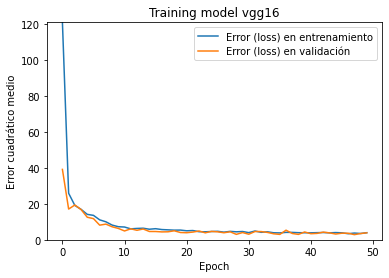

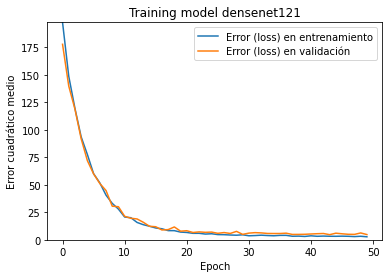

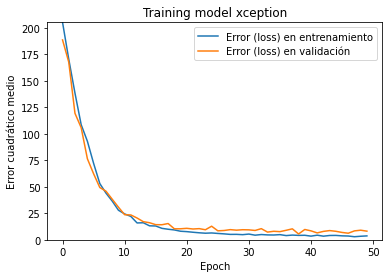

In [20]:
# Definimos el número de epochs y los modelos a entrenar para el entrenamiento de los modelos
epochs=50
models=['VGG16','DenseNet121', 'Xception']
histories=[]
evals=[]

# Entrenamos y evaluamos los modelos considerados
for model_name in models:
  # Construimos el modelo
  model=retrive_model(model_name=model_name)

  # Entrenamos el modelo
  history = model.fit_generator(train_data_gen, 
                      epochs=epochs, 
                      verbose=2, 
                      steps_per_epoch=train_data_gen.samples//train_data_gen.batch_size,
                      validation_data=val_data_gen,
                      validation_steps=val_data_gen.samples//val_data_gen.batch_size)
  histories.append(history)

  # Evaluamos el modelo y mostramos el error cuadrático medio como medida del error
  test_sme = model.evaluate_generator(test_data_gen, 
                                      steps=test_data_gen.samples/test_data_gen.batch_size, 
                                      verbose=1)
  evals.append(test_sme)
 

# Función para imprimir las curvas loss-epoch de entrenamiento y validación
def plot_history(history):
  plt.figure()
  plt.title('Training model {}'.format(history.model.name))
  plt.xlabel('Epoch')
  plt.ylabel('Error cuadrático medio')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Error (loss) en entrenamiento')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label='Error (loss) en validación')
  plt.legend()
  plt.ylim([0, max(1,max(np.array(history.history['loss'])))])


# Generamos los gráficos loss-epoch
# Mostramos información sobre el error min y máx durante el entrenamiento y el sme de la evaluación
for idx,model in enumerate(models):
  plot_history(histories[idx])
  print("Máximo error:",max(np.array(histories[idx].history['loss'])))
  print("Mínimo error:",min(np.array(histories[idx].history['loss'])))
  print("Model: {}\tSME: {}".format(model, evals[idx]))
